# B8 Software Suite: Analysis of XSPEDS data using Single Photon Counting and Bragg Spectroscopy

### Author: Yufei Pei
College: Lady Margaret Hall

Supervisor: Prof Sam Vinko

## Overview: 
This software is used to analyse data collected in X-ray Single-Photon Energy-Dispersive Spectroscopy (XSPEDS) experiments. 

In these experiments, hot, dense plasma sources are created, and the photons emitted from them collected using CCD cameras to study the behaviour of such systems. We are in particular interested in extracting the spectrum of emission intensity vs. photon energy, which requires the identification of the energy of each photon as well as accurate counting of photons in each energy bins. The latter is done by the single-photon counting(SPC) algorithm, which takes the images as input and returns the positions of the photons identified;the former is achieved by making use of Bragg's law,

$$
    n \frac{hc}{E}=2d \sin\theta
$$

which associates the photon energy $E$ with the deflection angle $\theta$. Thus, by deflecting the emitted photons using crystals with known lattice spacing $2d$, we are able to set up a one-to-one correspondence between the position of the photon on the CCD camera and its energy, using the geometry of the experiment which can be extracted from the information on the CCD images. 

The major difficulties in the previous approach are presented by the presence of background noise and multi-photon events(MPE). The fluctuation of background noise may result in the identification of spurious events, whereas the presence of MPE, entangled clusters due to more than one photon, making it hard to determine the actual positions of each photon. 

This notebook is organized in the following way: in the first part, after importing the data, we present the SPC algorithm, making use of the gradient descent method; we also present an algorithm to eliminate the spurious events due to the fluctuation of noise, by maintaining that the number of electron-hole pairs created by photons, and thus the total brightness it created, must obeys Gaussian distribution, and thus the spurious events can be identified and eliminated. In the second part, using the result of the SPC section, We present methods to identify the spectral lines, and use the energy values of them known to us to determine the geometry, and in the end plot the spectrum.

## Module importation

At the beginning, the program imports the module required.

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import h5py
import itertools
import numpy as np
from PIL import Image
from scipy.stats import logistic
from scipy.stats import chi2
from scipy.stats import poisson
from scipy.stats import mode
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.optimize import leastsq
from scipy.optimize import fsolve
import math
from copy import deepcopy
from statistics import mean
import time
import csv

## Importing the data

Imports the data in hdf5 format, and generate some basic information of the data.


<b><u>Enter the path of the data file here:</u></b>

In [21]:
hdf5_file_address = "sxro6416-r0504.h5"

<i>NB: This part of the code is provided by the supervisor at the beginning of the project.</i>

In [22]:
def import_images(f_name):
    
    # Name of the hdf file that contain the data we need
    # Open the hdf5 file, use the path to the images to extrate the data and place
    # it in the image data object for further manipulation and inspection.
    datafile = h5py.File(f_name, 'r')
    image_data = []
    for i in itertools.count(start=0):
        d = datafile.get(f'Configure:0000/Run:0000/CalibCycle:{i:04d}/Princeton::FrameV2/SxrEndstation.0:Princeton.0/data')
        if d is not None:
            # actual image is at first index
            image_data.append(d[0])
        else:
            break

    # Tell me how many images were contained in the datafile
    print(f"Loaded {len(image_data)} images")

    return image_data

image_data = import_images(hdf5_file_address)

KeyboardInterrupt: 

We have imported an array of images, each of them having dimensions $2048\times2048$ and entries between 0 and a few hundreds, representing the intensity value, or ADU value, of each pixel of the CCD camera. To have a look of the images, we plot one of them:

In [ ]:
# Change the size of the plot used in this notebook
plt.rcParams["figure.figsize"]=[12, 12];
plt.yticks(fontsize = 15);
plt.xticks(fontsize = 15);

plt.imshow(image_data[1])
plt.colorbar()

Plot the histogram of the ADU value of each pixels in one of the images in `image_data`:

In [ ]:
plt.hist(image_data[1].flatten(), bins = 150);
plt.yscale('log')
plt.xlim([0,400]);

From the above histagram, we are able to see the large pedestal, a normal-distributed peak on the left around $\mathrm{ADU}=50$ representing the background noise, and the signals on the right corresponding to photon events. We also identify some spurious bright spots in the image with too large ADU values; these will be filtered in the algorithm.

## Single Photon Counting

The SPC algorithm is build on the assumption that each photon event is associated with a 2-dimensional Gaussian distribution
$$
    I(x,y)=\frac{A}{\sigma_x \sigma_y }\exp\left(-\frac{(x-x_0)^2}{2\sigma_x^2}-\frac{(y-y_0)^2}{2\sigma_y^2}\right)
$$
and that the increment in the ADU value of each pixel is given by the integration of such a distribution within:
$$
\begin{aligned}
    \mathrm{ADU_G}(i,j)&=\int_i^{i+1}\int_j^{j+1}I(x,y)\mathrm{d}y\mathrm{d}x
    \\
    &=\frac{\pi}{2}A\left[\mathrm{erf}\left(\frac{i+1-x0}{\sqrt{2}\sigma_x}\right)-\mathrm{erf}\left(\frac{i-x0}{\sqrt{2}\sigma_x}\right)\right]\left[\mathrm{erf}\left(\frac{j+1-y0}{\sqrt{2}\sigma_y}\right)-\mathrm{erf}\left(\frac{j-y0}{\sqrt{2}\sigma_y}\right)\right]
\end{aligned}
$$

Therefore, our algorithm should find the peaks of ADU values in the image, identify a Gaussian distrubition that best resembles the entries around it and return the parameters $x_0,y_0,\sigma_x,\sigma_y,A$. This is achieved by the SPC algorithm, which takes each image in `image_data` as input and returns the position and the intensity of the photon.

### Step 0: Creating a demo data

A demo data, saved in `demo_data.csv`, is used to demonstrate how the SPC algorithm works.

It is the portion `[492:525, 1308:1340]` of the second image provided.

In [ ]:
# Import the demo data, convert it in to a numpy array
demo_data = []
with open('demo_data.csv', 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        demo_data.append(list(map(int, list(row))))
demo_data = np.array(demo_data)

# Plot the demo data
plt.imshow(demo_data)
plt.colorbar()

### Step 1: Image normalisation

<u>Goal of this step:</u> Normalise the images, so as to set the mean of the pedestals and thus the noise contribution to be 0.

Since it is found that in some images, the bottom is brighter than the top, image normalisation is done by cutting the image horizontally into `norm_cut_num` strips, with each strip having a height of `2048/norm_cut_num`, and subtracting each entry in the strip with the mode of the strip. This guarantees that the mode of the Gaussian background noise is set to 0 throughout the image. From the properties of Gaussian distributions, this also guarantees that the mean goes to 0. <i>NB: The demo data have been normalised in such a way.</i>

In [ ]:
#Set the number of strips to cut
norm_cut_num = 128

In [ ]:
def image_normalisation(im, cut_num):
    
    # Input: the image; the number of strips to cut
    # Output: the normalised image
    
    # Make a copy of the input data, using the deepcopy function to ensure that im remains unchanged:
    dat = deepcopy(im.astype(int))
    # NB: astype(int) is added to convert the entries of im from unsigned int (0-65536) to signed int.
    
    # Make sure that cut_num is a factor of the size of the image, i.e. 2048. If not, raise an error.
    try:
        cut_height = int(2048/cut_num)
        if(cut_height * cut_num != 2048):
            raise ValueError('Invalid norm_cut_num')
    except ValueError as e:
        print('Error: ', e)
    
    # Normalise the image
    for i in range(32):
        # Find the mode of the strip; if multiple modes are found, select the minimum of them
        im_mode = min(mode(dat[i*64:(i+1)*64,:].flatten())[0])
        
        dat[i*64:(i+1)*64,:] = dat[i*64:(i+1)*64,:].astype(int) - im_mode
    
    return dat


# Applying this function to our image_data
for i in range(len(image_data)):
    image_data[i] = image_normalisation(image_data[i], norm_cut_num)


Checking the norm of the pedestal has been set to 0 by plotting the histogram:

In [ ]:
plt.hist(image_data[1].flatten(), bins = 150);
plt.yscale('log')
plt.xlim([-50,350]);

The algorithm then sets the pixels near the boundaries to be 0, as it is noticed that pixels near the boundaries may have different ADU values, potentially due to instrumental error.

In [ ]:
def boundary_setting(im):
    
    # Input: a normalised image
    # Output: the image, with the entries near the edges set to 0
    
    # Find the height and width of im
    h = im.shape[0]
    w = im.shape[1]
    
    dat = deepcopy(im.astype(int))
    
    # Set the entries near the boundary to 0
    for i in range(h):
        for j in range(w):
            if((i < 2 or i > h - 2) or (j < 4 or j > w - 2)):
                dat[i, j]=0
                
    return dat

# Applying this function to our normalised image_data
for i in range(len(image_data)):
    image_data[i] = boundary_setting(image_data[i])

### Step 2: Thresholding & box assignment

<u>Goal of this step:</u> Split each image into small portions that can be considered separately.

We assume that each photon event can only have have influence in the surrounding pixels; pixels having a distance greater than 2px cannot be influenced. Hence, if one photon or a set of photons is separated by a distance of at least 2px from all other photons, we can single it/them out to be analysed separately.

Using this, the algorithm in this step (1) Applies a threshold to the images, to find the pixels with large ADUs; (2) Assign rectangular 'boxes' to enclose the large-ADU pixels and its surroundings, making sure that (i) events in different boxes are separated and do not have influence on each other and (ii) if there are more than one events in one box, then these events are entangled. The contents within these boxes are going to be considered separately when, in the next step, exact positions of the photon events are to be found.

#### 2.1 Thresholding

We select the threshold value to be 30; this allows most photon events and at the same time a small portion of noises. The noise-cancelling algorithm is presented in step 5.

In [ ]:
# Set the threshold:
thres = 30

In [ ]:
# The thresholding algorithm.

def thresholding(data, threshold):
    
    # Input: a normalised image
    # Output: A matrix, having the same dimensions of the input image, with each entry being 0 if the corresponding entry in the input 
    #         matrix is < threshold, and 1 if it's >= threshold
    
    def compare(val):
        if(val >= threshold):
            return 1
        else:
            return 0
    
    label_matrix = [[compare(data[i, j]) for j in range(data.shape[1])] for i in range(data.shape[0])]
    
    return label_matrix

Applying it on our cute little demo data: 

Yellow pixels are entries greater than threshold and purple pixels are other entries.

In [ ]:
demo_label_matrix = thresholding(demo_data, thres)
plt.imshow(demo_label_matrix)
plt.colorbar();

#### 2.2 Box assignment

In [ ]:
# Establish a class of box, containing the coordinate of the edges, as well as the width and height of it.

class box:
    'used to enclose photon events'
    
    def __init__(self, xmin, ymin, xmax, ymax):
        self.x_min = xmin
        self.y_min = ymin
        self.x_max = xmax
        self.y_max = ymax
        
        self.width = xmax - xmin + 1
        self.height = ymax - ymin + 1
    
    def params(self):
        # Return the parameters of the box
        return [self.x_min, self.y_min, self.x_max, self.y_max]
    
    def hw(self):
        # Find the shape of the box
        return [self.height, self.width]

In [ ]:
# The box assignment function

def boxing(thres_matrix, output = 'None'):
    
    # Input: the threshold matrix, coming from the thresholding() function
    # Output: A list of boxes identified within the image. 
    
    # The 'output' parameter determines whether the function prints some information for 
    # debugging or demonstration purposes.
    
    # Create a copy of the input matrix, so that it will not be changed
    m = np.array(deepcopy(thres_matrix))
    
    # Initialise the box list
    box_list = []
    
    #Prepare for plotting the dataset, if needed
    if(output != 'None'):
        fig, ax = plt.subplots(1)
                               
    # Search for entry 1's in the input matrix
    for i in range(m.shape[0]):
         for j in range(m.shape[1]):
            if(m[i, j] == 1):
                # An entry 1 is found: firstly, the box only contains this entry and its surrounding 3*3.
                x = i
                y = j
                
                x_min = x - 1
                y_min = y - 1
                x_max = x + 1
                y_max = y + 1
                
                # Search for if there is any more entry 1's in the surrounding 5*5:
                while(True):
                    # Flag identifying the presence of entry 1's
                    flag = 0
                    
                    # Set the current entry to 0, in order to avoid double counting
                    m[x, y] = 0
                    
                    for ii in range(x_min - 1, x_max + 2):
                        for jj in range(y_min - 1, y_max + 2):
                            # Check if the search has reached the boundary of the image; if so, skips.
                            if((ii >= m.shape[0]) or (jj >= m.shape[1])): 
                                continue
                            
                            elif(m[ii, jj] == 1): # More entry 1's are found
                                flag = 1
                                
                                # Set this entry to 0, in order to avoid double counting
                                m[ii, jj] = 0
                                
                                # Enlarge the box to accommodate all these entries found in this way,
                                # as they are assumed to be entangled and must be considered simultaneously
                                x_min = min(x_min, ii - 1)
                                y_min = min(y_min, jj - 1)
                                x_max = max(x_max, ii + 1)
                                y_max = max(y_max, jj + 1)
                                
                    # this searching process must be iterated until no more entry 1's are found 
                    # in the box's ambiance, and that it is safe to consider the elements whthin 
                    # this box separately.
                    if(flag == 0):
                        break
                
                #Append our box identified to the box list
                b = box(x_min, y_min, x_max, y_max)
                box_list.append(b)
                
                # Generate output, if needed
                if(output != 'None'):
                    print('box created containing [%d:%d, %d:%d]' % (x_min, x_max, y_min, y_max))
                    
                    # Add a rectangle representing this box to the plot
                    box_rect = patches.Rectangle((y_min - 0.5, x_min - 0.5), b.hw()[0], b.hw()[1],
                                                 linewidth = 1, edgecolor = 'r', facecolor = "none")
                    ax.add_patch(box_rect)

    # Generate output, if needed
    if(output != 'None'):
        plt.imshow(thres_matrix)
        plt.colorbar()
        plt.show()
    
    return box_list

Applying it on our beloved demo data:

In [ ]:
demo_box_list = boxing(demo_label_matrix, output = 'Yes please!')

### Step 3: Locating the exact photon position and intensity within each box using gradient descent method

<u>Goal of this step</u>: within each box, find the set of parameters $x_0,y_0,\sigma_x,\sigma_y,A$ for each photon that yields the least square error

$$
    \mathrm{error}=\sum_{i,j}(\mathrm{ADU}(i,j)-\mathrm{ADU_G}(i,j))^2
$$
where $\mathrm{ADU}(i,j)$ is the ADU value after normalisation.

This optimisation task is done by the gradient descent method. First, find the number of photons within each box, and an initial estimation of their parameters. Then, use the gradient descent method to optimise the parameters until convergence is reached.

#### 3.1 Preparation

We start by defining two constants, $\pi$ and $\sqrt{2}$, which will be frequently used in the calculation:

In [ ]:
Pi = np.pi
Sqrt2 = np.sqrt(2)

We also define an array containing values of error functions($\mathrm{erf}$) of -10 to 10 that will be frequently evaluated in the calculations.

This array, `Erf`, satisfies: for an integer $x$ with $-10^6\le x\le 10^6$, 
$$
    \mathtt{Erf[x]} = \mathrm{erf}\left(\frac{x}{10^5}\right)
$$
where negative entries means counting backward as usual. Since the difference between $\mathrm{erf}(10)$ and 1(as well as $\mathrm{erf}(-10)$ and -1) is neglegible, we are able to use the value of $\mathrm{erf}(10)$ to replace error functions of values greater than 10.

In [ ]:
Erf = []
for i in range(10**6 + 1):
    Erf.append(math.erf(i / 10**5))
for i in range(-10**6 , 0):
    Erf.append(math.erf(i / 10**5))

The algorithm first establishing a class of photon events(PE), containing the five parameters characterising it, namely $x_0,y_0,\sigma_x,\sigma_y,A$, as well as the width and height of the box in which it lives. It moreover contains the theoretical ADU value, $\mathrm{ADU}_\mathrm{G}$, caused by this photon alone. The actual theoretical ADU value is the linear superpositions of contributions from each photon.

Recall that $\mathrm{ADU}_\mathrm{G}$ is given by:
$$
\begin{aligned}
    \mathrm{ADU_G}(i,j)&=\int_i^{i+1}\int_j^{j+1}I(x,y)\mathrm{d}y\mathrm{d}x
    \\
    &=\frac{\pi}{2}A\left[\mathrm{erf}\left(\frac{i+1-x0}{\sqrt{2}\sigma_x}\right)-\mathrm{erf}\left(\frac{i-x0}{\sqrt{2}\sigma_x}\right)\right]\left[\mathrm{erf}\left(\frac{j+1-y0}{\sqrt{2}\sigma_y}\right)-\mathrm{erf}\left(\frac{j-y0}{\sqrt{2}\sigma_y}\right)\right]
\end{aligned}
$$

In [ ]:
# Defining a function that calculates the part within the square bracket of the above expression:
def entry(i, x0, s):
    
    # Calculate the variable in the first and second pairs of parentheses, applying bounds of [-10, 10] to it from reasons
    # discussed above
    var_1 = max(-10, min(10, (-x0 + i + 1) / (Sqrt2 * s)))
    var_2 = max(-10, min(10, (-x0 + i ) / (Sqrt2 * s)))
    
    # Convert the variables calculated into array indices for Erf[], and obtain the final value
    
    i1 = math.floor(var_1 * 100000)
    i2 = math.floor(var_2 * 100000)
    
    return Erf[i1] - Erf[i2]

class photon_event:
    'A photon event, the box in which it lives, and the ripple of ADU values it creates'
    
    def __init__(self, y0, x0, sx, sy, w, h, A):

        self.x0 = x0
        self.y0 = y0
        self.sx = sx
        self.sy = sy
        self.A = A
        
        # Width and height of the box
        self.h = h
        self.w = w
        
        # Generate the distribution matrix, ADU_G of the photon. 
        ls1=[entry(i, x0, sx) for i in range(w)]
        ls2=[entry(j, y0, sy) for j in range(h)]
        self.dist_matrix=1/2 * Pi * self.A * np.outer(ls1, ls2)

    # A function returning the five parameters of the photon 
    def params(self):
        return [self.x0, self.y0, self.sx, self.sy, self.A]
    
    # A function to change the parameter of the photon itself, but not the box
    def new_value(self, para_ls):
        
        self.x0, self.y0, self.sx, self.sy, self.A = para_ls
        
        # Alter the distribution matrix, ADU_G of the photon. 
        ls1=[entry(i, self.x0, self.sx) for i in range(self.w)]
        ls2=[entry(j, self.y0, self.sy) for j in range(self.h)]
        self.dist_matrix=1/2 * Pi * self.A * np.outer(ls1, ls2)

Define the error function:

In [ ]:
def error(pe_array, box_dat):
    
    # Input: a list of photon_event objects, as well as the data in the box containing these photons and them only
    # Output: the error in this box
    
    # Find ADU_G, which is the linear superpositions of contributions from each photon
    tot_dist_matrix = sum([event.dist_matrix for event in pe_array])
    
    # Return the total error
    return sum(((box_dat - tot_dist_matrix)**2).flatten())

The algorithm treats boxes with one photon event and boxes with more than one photon events differently. We need a criterion to classify the boxes at the initial stage. The criterion is as follows: if a box's height and width are both $\le4$, we classify this as a single photon event(SPE); otherwise, it is treated as a multi photon event(MPE), since, as described above, no single photon can extend its influence beyond 4 pixels. 

#### 3.2 Gradient descent: SPEs

We define the gradient descent optimisation function for single-photon events, which contains the following parts:

<b>Determination of initial values:</b>
We select the initial values for the SPE algorithm as follows: 

The initial `x0, y0` is select to be the mass center of the data
$$
    \mathtt{x0}^\mathrm{ini} = \frac{\sum_{i,j} \mathtt{dat[i, j]} \times \mathtt{i}}{\sum_{i,j} \mathtt{dat[i, j]}} \mathtt{ + 0.5}
$$
$$
    \mathtt{y0}^\mathrm{ini} = \frac{\sum_{i,j} \mathtt{dat[i, j]} \times \mathtt{j}}{\sum_{i,j} \mathtt{dat[i, j]}} \mathtt{ + 0.5}
$$

where `dat` is the data inside the box. If this results in a coordinate that is outside of the box, we instead select it to be at the center of the pixel with maximum ADU value. 

The initial `sx, sy` is selected to be 
$$
    \mathtt{sx^{\mathrm{ini}} = 0.2 + 0.2}\times \frac{\mathtt{dat[im + 1, jm] + dat[im - 1, jm]}}{\mathtt{dat[im, jm]}}
$$
$$
    \mathtt{sy^{\mathrm{ini}} = 0.2 + 0.2}\times \frac{\mathtt{dat[im, jm + 1] + dat[im, jm - 1]}}{\mathtt{dat[im, jm]}}
$$
where `im, jm` is the coordinate of the maximum entry.

The initial `A` is selected randomly between $22$ and $25$.

<b>Gradient descent:</b>
Using these initial values, the program starts a loop to alter them until a minimum of the error function is reached. Within each iteration, gradient descent is completed using the `descent` function, defined below, which updates the photon parameters by checking the change of error when each of them are shifted by a small amount. After this we check if convergence is reached by finding the difference between the current error and the error `iter_diff` iterations earlier, and compare it with `err * conv_crit`. 

<b>Final check: had we mistaken an MPE with an SPE?</b> 
    If the box has size $3\times3$ or $3\times4$ then this is unlikely; moreover, even if there are two photons, it is likely that the photon we found using the SPE algorithm has an intensity equals to the combination of them. For $4\times4$ boxes a check need to be added: if, upon convergence, the error is still greater than `err_max`, this box will be processed instead by the MPE algorithm. 

In [ ]:
# Set the step length for each parameters
step_x = 0.01
step_y = 0.01
step_sx = 0.005
step_sy = 0.005
step_A = 0.3

# Set the descent factor: a factor to be multiplied when deciding the amount of change of parameters in each iteration
descent_factor = 0.2

# We require the standard errors to be bounded; define the minimum and maximum allowed values:
s_min = 0.2
s_max = 0.6

# Set the other parameters described above
iter_diff = 10
conv_crit = 1/40
err_max = 1600

# Set the miximum number of iterations
max_iter = 400

In [ ]:
def descent(pe_ls, step_ls, dat):
    
    # Input: a list of photon events; the list of their step lengths; the data within the box considered.
    # Output: the updated list of parameters.
    
    # Calculate the photon number and the total error
    photon_n = len(pe_ls)
    err = error(pe_ls, dat)
    
    # The list of new parameters
    new_param_ls = []
    
    for n in range(photon_n):
        # Read the parameters of the current photon
        param = pe_ls[n].params()
        
        # Create five lists, in each of which one parameter is altered by its step length
        new_params = param + np.diag(step_ls)
        
        # Create the array storing the error differences and calculate the values of them.
        # NB for efficiency purposes a for loop is not used.
        err_diff = np.zeros(5)
        
        pe_ls[n].new_value(new_params[0])
        err_diff[0] = error(pe_ls, dat) - err
        
        pe_ls[n].new_value(new_params[1])
        err_diff[1] = error(pe_ls, dat) - err
        
        pe_ls[n].new_value(new_params[2])
        err_diff[2] = error(pe_ls, dat) - err
        
        pe_ls[n].new_value(new_params[3])
        err_diff[3] = error(pe_ls, dat) - err
        
        pe_ls[n].new_value(new_params[4])
        err_diff[4] = error(pe_ls, dat) - err
        
        # Generate the updated parameters
        # NB parameters are shifted in this way by an amount proportional to descent_factor, the gradient, and
        # the SQUARE of the step length. This is to accommodate the different ranges of them(e.g. some 0.1s for
        # sx and sy but 0-100 for A)
        new_param_ls.append(-np.array(step_ls) * descent_factor * err_diff + param)
        
        # Check if the standard errors and intensities are within boundary
        new_param_ls[n][2] = max(s_min, min(s_max, new_param_ls[n][2]))
        new_param_ls[n][3] = max(s_min, min(s_max, new_param_ls[n][3]))
        new_param_ls[n][4] = max(0, new_param_ls[n][4])
    
    return new_param_ls, err

step_ls = [step_x, step_y, step_sx, step_sy, step_A]

def gradient_descent_single(b, image_data, output = 'None'):
    
    # Input: a box classified as SPE, and the image data in which it lives
    # Output: the five parameters of the photon, and a boolean flag checking if we have mistaken an MPE as an SPE.
    
    # The 'output' parameter determines whether the function prints some information for 
    # debugging or demonstration purposes.
    
    # Generate the box data
    xmin, ymin, xmax, ymax = b.params()
    xmax = xmax + 1
    ymax = ymax + 1
    dat = np.array(image_data[xmin:xmax, ymin:ymax])
    
    # Generate output, if needed
    if(output != 'None'):
        print('Box data:')
        print(dat)
    
    # Generate initial x0, y0
    xavg = 0
    yavg = 0
    for i in range(dat.shape[0]):
        for j in range(dat.shape[1]):
            xavg = xavg + i * dat[i, j]
            yavg = yavg + j * dat[i, j]
    
    x = xavg / max(sum(dat.flatten()), 1) + 0.5
    y = yavg / max(sum(dat.flatten()), 1) + 0.5
    
    h, w = b.hw()
    # Check if the initial condition determined in such a way is erroneous; if so, use the alternative method
    # and select x, y to be at the center of the pixel with maximum entry 
    [i0, i1] = np.unravel_index(dat.argmax(), dat.shape)
    if(x < 0 or x > h or y < 0 or y > w):
        x = i0 + 0.5
        y = i1 + 0.5
    
    # sx and sy are required to be bounded between smin and smax
    s_x = min(max(0.2 + 0.2 * (dat[i0 + 1, i1] + dat[i0 - 1, i1]) / dat[i0, i1], s_min), s_max)
    s_y = min(max(0.2 + 0.2 * (dat[i0, i1 + 1] + dat[i0, i1 - 1]) / dat[i0, i1], s_min), s_max)
    
    # Generate initial A
    A = 22 + np.random.uniform() * 3
    
    # Generate the photon event
    spe = photon_event(y, x, s_x, s_y, w, h, A)
    if(output != 'None'):
        print('Initial guesses of the parameters are: \n x=%f, y=%f, sx=%f, sy=%f, A=%f' %(x, y, s_x, s_y, A))
        print('with a distribution matrix of:')
        print(spe.dist_matrix.astype(int))
    # Generate the list of parameters and steps
    para_ls = [[x, y, s_x, s_y, A]]
    
    # Create an array to store the errors of each step
    err_array = []
    
    if(output != 'None'):
        print('-----------Iteration starts-------------')
        
    for i in range(max_iter):
        
        # Use descent to obtain the new parameters and the current error, and add the latter to err_array
        new_param_ls, err = descent([spe], step_ls, dat)
        err_array.append(err)
        
        # Alter the photon event
        spe.new_value(new_param_ls[0])
        para_ls[0] = spe.params()
        
        if(output != 'None' and i%10 == 0):
            # Print the parameters every 10 iterations
            print('Iteration #%d: x=%f, y=%f, sx=%f, sy=%f, A=%f' %
                  (i + 1, para_ls[0][0], para_ls[0][1], para_ls[0][2], para_ls[0][3], para_ls[0][4]))
            print('Current error:%f' % err)
        
        # Check if convergence is reached
        if(i >= iter_diff and err_array[i - iter_diff] - err <= err * conv_crit):
            if(output != 'None'):
                print('Convergence reached at iteration #%d: x=%f, y=%f, sx=%f, sy=%f, A=%f' %
                  (i + 1, para_ls[0][0], para_ls[0][1], para_ls[0][2], para_ls[0][3], para_ls[0][4]))
                print('Current error:%f' % err)
                print('-----------Iteration ends-------------')
                print('Final distribution matrix:')
                print(spe.dist_matrix.astype(int))
            break

    # Postprocessing: check if we've mistaken an MPE as an SPE
    flag = 0 
    if(b.hw() == [4,4] and err > err_max):
        flag = 1
    
    x, y, s_x, s_y, A = para_ls[0]   
    return [x, y, s_x, s_y, A, flag]

As an example, apply the algorithm to one of the boxes in the demo data:

In [ ]:
gradient_descent_single(demo_box_list[11], demo_data, output = 'yes please');

#### 3.3 Gradient descent: MPEs

The gradient descent optimisation function for multi-photon events contains the following parts:

<b>Determination of initial values and initial guess of photon numbers within:</b>
As an initial guess, we place a photon event with `sx = 0.4, sy = 0.4` and `A` randomly selected between 22 and 25 at the center of each pixel which (i) is above `thres`, and (ii) is greater than all eight adjacent pixels.

<b>Gradient descent #1:</b>
Run a gradient descent until convergence is reached.

<b>Attempts to add more photons in this box:</b>
If, upon subtracting the actual data with the distribution matrix of each photon, the remainder, named `dat_res`, is examined: if (i) there is one entry greater than `thres`, or (ii) there are two entries greater than `thres - 10`, then it is attempted to add one more photon event at the center of the pixel with maximum entry in `dat_res`. We then compare the error to the previous error and decide if we take the new arrangement, and if so, the above process is iterated until conditions are not met.

In [ ]:
# Set the maximum # of photons allowed in each event:
max_photon = 20

In [ ]:
def gradient_descent_multi(b, image_data, output = 'None'):
    
    # Input: a box classified as MPE, and the image in which it lives
    # Output: the five parameters of the photon, and a boolean flag checking if we have mistaken an MPE as an SPE.
    
    # The 'output' parameter determines whether the function prints some information for 
    # debugging or demonstration purposes.
    
    # Generate the box data
    xmin, ymin, xmax, ymax = b.params()
    xmax = xmax + 1
    ymax = ymax + 1
    dat = np.array(image_data[xmin:xmax, ymin:ymax])
        
    # Generate output, if needed
    if(output != 'None'):
        print('Box data:')
        print(dat)
        
    # ------------Stage 1: initial guess of photon numbers and parameters, gradient descent #1--------------
    
    # Initialise the photon number, the positions of photons and the intensities
    photon_n = 0
    x = np.array([])
    y = np.array([])
    sx = np.array([])
    sy = np.array([])
    A = np.array([])
    
    # Initialise the list of photon events
    pe_array = []
    
    h, w = b.hw()
    for i in range(w):
        for j in range(h):
            if(dat[i, j] >= thres):
                if(i == 0 or i == w - 1 or j == 0 or j == h - 1):
                    # Check if, erroneously, there is a pixel >=30 at the boundary of the box (due to errors in the boxing process);
                    # if so, set this to 0
                    dat[i, j] = 0
                elif(dat[i, j] >= 
                     max(dat[i + 1, j] - 1, #The -1 here and below is to prevent double counting if there exists two equal maxima
                         dat[i - 1 ,j],
                         dat[i, j + 1] - 1,
                         dat[i, j - 1],
                         dat[i + 1, j + 1] - 1,
                         dat[i + 1, j - 1] - 1,
                         dat[i - 1, j - 1],
                         dat[i - 1, j + 1])):
                    photon_n = photon_n + 1
                    x = np.append(x, i + 0.5)
                    y = np.append(y, j + 0.5)
                    sx = np.append(sx, 0.4)
                    sy = np.append(sy, 0.4)
                    A_init = 22 + np.random.uniform() * 3
                    A = np.append(A, A_init)
                    
                    pe = photon_event(j + 0.5, i + 0.5, 0.4, 0.4, w, h, A_init)
                    pe_array.append(pe)
                    
                    # Generate output, if needed
                    if(output != 'None'):
                        print('Photon created at x=%g, y=%g' % (pe.x0, pe.y0))
    
    if(output != 'None'):
        print('%d photon(s) initialised.' % photon_n)
        print('----------Initial iteration starts----------')
        
    para_ls = np.transpose([x, y, sx, sy, A])
    err_array = []
    
    for i in range(max_iter):
        
        # Use descent to obtain the new parameters and the current error, and add the latter to err_array
        new_param_ls, err = descent(pe_array, step_ls, dat)
        err_array.append(err)

        # Change the parameters of the photons
        for n in range(photon_n):
            pe_array[n].new_value(new_param_ls[n])
            para_ls[n] = new_param_ls[n]
            if(output != 'None' and i%10 == 0):
                # Print the parameters every 10 iterations
                print('Iteration #%d: photon no. %d has x=%f, y=%f, sx=%f, sy=%f, A=%f' %
                    (i + 1, n + 1, para_ls[n][0], para_ls[n][1], para_ls[n][2], para_ls[n][3], para_ls[n][4]))
            
        # Check if convergence is reached
        if(i >= iter_diff and err_array[i - iter_diff] - err <= err * conv_crit):
            if(output != 'None'):
                print('Convergence reached at iteration #%d:' % (i + 1))
                for m in range (photon_n):
                    print('Photon no. %d has x=%f, y=%f, sx=%f, sy=%f, A=%f' %
                      (m + 1, para_ls[m][0], para_ls[m][1], para_ls[m][2], para_ls[m][3], para_ls[m][4]))
                    print('Distribution matrix of this photon:')
                    print(pe_array[m].dist_matrix.astype(int))
                print('Current error:%f' % err)
                print('-----------Initial iteration ends-------------')
            break
    
    x, y, sx, sy, A = np.transpose(para_ls)
    
    # ------------Stage 2: attempt to add more photon within the box to further reduce error-------------
    
    for num in range(photon_n, max_photon):
        
        # Store the current values
        err_tmp = error(pe_array, dat) 
        x_tmp ,y_tmp, sx_tmp, sy_tmp, A_tmp = np.transpose(para_ls)
        
        # Calculate the residual distribution 
        dat_res = deepcopy(dat)
        for pe in pe_array:
            dat_res = dat_res - pe.dist_matrix.astype(int)
        
        if(output != 'None'):
            print('The current residual distribution:')
            print(dat_res)
        
        # From the residual matrix, check if another photon can be added
        dat_sorted = sorted(dat_res.flatten())
        if((dat_sorted[-1] < thres and dat_sorted[-2] < thres - 10)):
            if(num >= 2): # Another photon must be added if only one photon exists at this stage.
                if(output != 'None'):
                    print('No more photons to be added. Gradient descent ends.')
                break
                
        # Add one photon at the maximum entry of dat_res
        x_new, y_new = np.unravel_index(dat_res.argmax(), dat_res.shape)
        if(output != 'None'):
            print('One more photon added at x=%g, y=%g; there are currently %d photons in total.' %(x_new + 0.5, y_new + 0.5, num + 1))
        x = np.append(x, x_new + 0.5)
        y = np.append(y, y_new + 0.5)
        
        # Reset all other parameters
        sx = np.zeros(num + 1) + 0.4
        sy = np.zeros(num + 1) + 0.4
        A = np.random.uniform(size = num + 1) * 3 + 22
        para_ls = np.transpose([x, y, sx, sy, A])
        
        # Reset all photon events
        pe_array = []
        for i in range(num+1):
            pe_array.append(photon_event(y[i], x[i], sx[i], sy[i], w, h, A[i]))
        
        err_array = []
        if(output != 'None'):
            print('----------Iteration #%d starts----------' % (num + 1))
        for i in range(max_iter):

            # Use descent to obtain the new parameters and the current error, and add the latter to err_array
            new_param_ls, err = descent(pe_array, step_ls, dat)
            err_array.append(err)

            # Change the parameters of the photons
            for n in range(num + 1):
                # Alter each parameter using the descent function
                # A loop is not used here for efficiency
                pe_array[n].new_value(new_param_ls[n])
                para_ls[n] = new_param_ls[n]
            # Check if convergence is reached
            if(i >= iter_diff and err_array[i - iter_diff] - err <= err * conv_crit):
                if(output != 'None'):
                    print('Convergence reached at iteration #%d:' % (i + 1))
                    for m in range (num + 1):
                        print('Photon no. %d has x=%f, y=%f, sx=%f, sy=%f, A=%f' %
                          (m + 1, para_ls[m][0], para_ls[m][1], para_ls[m][2], para_ls[m][3], para_ls[m][4]))
                        print('Distribution matrix of this photon:')
                        print(pe_array[m].dist_matrix.astype(int))
                    print('Current error:%f' % err)
                    print('-----------Iteration #%d ends-------------' % (num + 1))
                break
                
        # Compare the error: if adding a photon does not reduce the error, select the old arrangements and break
        if(err >= err_tmp - 5):
            err = err_tmp
            x = x_tmp
            y = y_tmp
            sx = sx_tmp
            sy = sy_tmp
            A = A_tmp
            if(output != 'None'):
                print('Adding this photon however did not reduce error. Returning to the older configuration with %d photons. Gradient descent ends.' 
                      % num)
            break
            
        x, y, sx, sy, A = np.transpose(para_ls)
    
    return [x, y, A, err]

As an example, apply the algorithm to one of the boxes in the demo data:

In [ ]:
gradient_descent_multi(demo_box_list[7], demo_data, output = 'yes please');

### Step 4: Running the SPC algorithm

We now create a function that completes the task of single photon counting, invoking the SPE and MPE functions defined above.

In [ ]:
# Establish a class to store the results:
class photon_event_result:
    'The result of photon event processed. This includes the coordinates and intensity of the event, as well as its classification.'

    def __init__(self, event_type, x, y, A):
        self.x = x
        self.y = y
        self.A = A
        self.type = event_type # event_type is 's' for SPEs and 'm' for MPEs
        

def single_photon_counting(im_array):
    
    # Input: an array of normalised image to be processed
    # Output: an array of photon_event_result objects, containing the photons identified.
    
    # an index to count the number of images
    image_no = 0
    
    photon_n = 0 # No. of photons found
    s_n = 0 # No. of single photons found
    m_n = 0 # No. of photons in MPEs found
    
    # Start timing
    start = time.time()
    
    #Initialize the photon event result object list
    per_list = []
    
    for im in im_array:
        image_no = image_no + 1
        print('\r', 'Preparing image #%d' % image_no, end = '', flush = True)
        
        # Find the list of boxes in this image
        box_list = boxing(thresholding(im, thres))
        box_count = 0
        box_photon_count = 0

        for b in box_list:
            box_count = box_count + 1
            
            # Display some information
            end = time.time()

            print('\rImage %d / %d, box %d / %d; # of photons in this image: %d; Total time elapsed: %.1f sec.' 
            % (image_no, len(im_array), box_count, len(box_list), box_photon_count, end - start), end = '', flush = True)

            if(b.hw()[0] <= 4 and b.hw()[1] <= 4): # Single photon events
                
                spe_event = gradient_descent_single(b, im)
                x, y, sx, sy, A, flag = spe_event
                
                if(flag == 0): # SPE confirmed
                    # Transform the x and y coordinates to that of the image
                    x = x + b.x_min - 0.5
                    y = y + b.y_min - 0.5
                    
                    per = photon_event_result('s', x, y, A)
                    per_list.append(per)
                    
                    photon_n = photon_n + 1
                    box_photon_count = box_photon_count + 1
                    s_n = s_n + 1
                    
                    continue
            
            #MPE confirmed
            mpe_event = gradient_descent_multi(b, im)
            
            for n in range(len(mpe_event[0])): # Iterate all photons found
                # Transform the x and y coordinates to that of the image
                x = mpe_event[0][n] + b.x_min - 0.5
                y = mpe_event[1][n] + b.y_min - 0.5
                A = mpe_event[2][n]
                
                per = photon_event_result('m', x, y, A)
                per_list.append(per)
                    
                photon_n = photon_n + 1
                box_photon_count = box_photon_count + 1
                m_n = m_n + 1 
    
        print(" Image Done.")

    print('Single photon counting finished.')
    print('%d SPEs found; %d MPEs found; total number of photons: %d' % (s_n, m_n, photon_n))
    print('Time elapsed: %f seconds' % (end - start))
    return per_list    

Demonstrating our single photon counting algorithm in the demo data, which have finally fulfilled its purposes:

In [ ]:
demo_results=single_photon_counting([demo_data])

In [ ]:
# Plot the boxes
fig, ax = plt.subplots(1)
for b in demo_box_list:
    box_rect = patches.Rectangle((b.y_min - 0.5, b.x_min - 0.5), b.hw()[0], b.hw()[1],
                                                 linewidth = 1, edgecolor = 'r', facecolor = "none")
    ax.add_patch(box_rect)

# Extract the data
demo_x, demo_y, demo_A = np.transpose([[per.x, per.y, per.A] for per in demo_results])

plt.scatter(demo_y, demo_x, color = 'red', marker = 'o', s = 12 * (np.array(demo_A) - 10))
plt.imshow(demo_data)

Now, run the single photon counting algorithm on our image data:

<b>Note: processing of each image would take tens of seconds to a few minutes, depending on the photon density in it. Processing an array of 20 images may take 1-2 hours. </b>

In [23]:
spc_result = single_photon_counting(image_data)

 Preparing image #1

NameError: name 'boxing' is not defined

Write a function to save the data in a csv file, with each line having three entries of `x, y, A`.

<b><u>Enter the path of the csv file to save the data here:</u></b>

In [27]:
csv_path = 'spc_data.csv'

In [28]:
def write_in_csv(spc_result, name):
    with open(name, 'w', newline = '') as file:
        writer = csv.writer(file)
        for per in spc_result:
            x = per.x
            y = per.y
            A = per.A
            t = per.type
            writer.writerow([x, y, A, t])

def read_from_csv(file_loc):
    with open(file_loc, mode = 'r') as file:
        csvFile = csv.reader(file)
        x_list = []
        y_list = []
        A_list = []   
        spc_result = []
        for lines in csvFile:
            x, y, A, t = lines
            spc_result.append(photon_event_result(t, float(x), float(y), float(A)))
    return spc_result

#write_in_csv(spc_result, name = csv_path)

In [29]:
# Uncomment the next line to read data from the csv file:
spc_result = read_from_csv(file_loc = csv_path)

### Step 5: Noise elimination

Up until this point, we have not considered the influence of the noise, which may fluctuate above the threshold and create low-intensity spurious events. We will now attempt to eliminate them.

The elimination of noise is based on the assumption that the distribution of `A`, the photon intensity, should be Gaussian. We plot the histogram of `A` below:

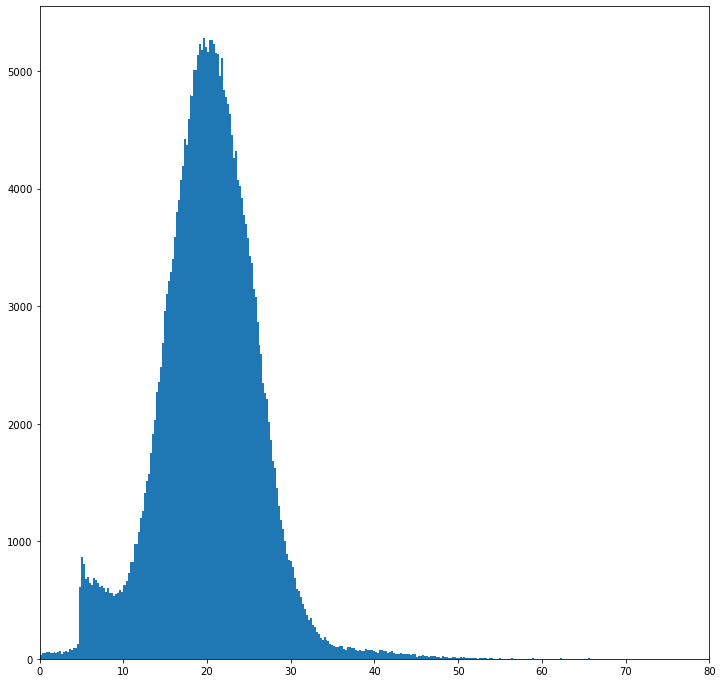

In [30]:
x_list = [per.x for per in spc_result]
y_list = [per.y for per in spc_result]
A_list = [per.A for per in spc_result]
plt.hist(A_list, bins = 500);
plt.rcParams["figure.figsize"]=[12, 12];
plt.xlim([0, 80]);

It can be seen that `A` indeed follows a Gaussian distribution, but the region below `A = 10` and above `A = 40` are spurious. The latter is due to that we sometimes count two photons at the same pixel or adjacent pixels as one; the former, on the other hand, is due to noise.

In our noise elimination process, we eliminated the spurious low-intensity events until a Gaussian distribution is restored on the left side. This is created by first fitting a Gaussian distribution using the middle section of the histogram, and eliminate events in each of the low-intensity bins until the remaining number of events conforms to the distribution fitted. For each event with `A < gauss_min`, with `gauss_min` the lower bound of the region with which we will perform the fit, the chance of keeping it is the ratio of the value of the Gaussian fit at `A` and the number of events in the bin in which it lives.

Also, in this process we generate the statistics of the number and the uncertainty of photons.

For the statistics of photon numbers, each valid photon with intensity `A` is counted as $A/\mu_A$ photons, where $\mu_A$ is the mean of the Gaussian fitted,

We also need to find the uncertainty of the photon number founded in this way. Two factors contribute to the uncertainty:

- Due to the probabilitistic approach of our filtering algorithm: each time we have a low-intensity event with probability $p$, no matter we select it or not, an uncertainty of $\sqrt{p(1-p)}$ is generated.

- The algorithm may consider two adjacent photon events to be one with large intensity by mistake. Whenever we see an event with intensity `A > gauss_max`, an uncertainty of $\sqrt{x(1-x)}$ is generated, where $x=A/\mu_A-1$, with a maximum of 1.

In [31]:
# Specify the boundaries of the region with which we are going to fit the Gaussian.
gauss_min = 12
gauss_max = 30

# Specify the number of bins that is going to be used in the following function to bin the events
_bins = 400

Total photon number: 283604 ± 10424


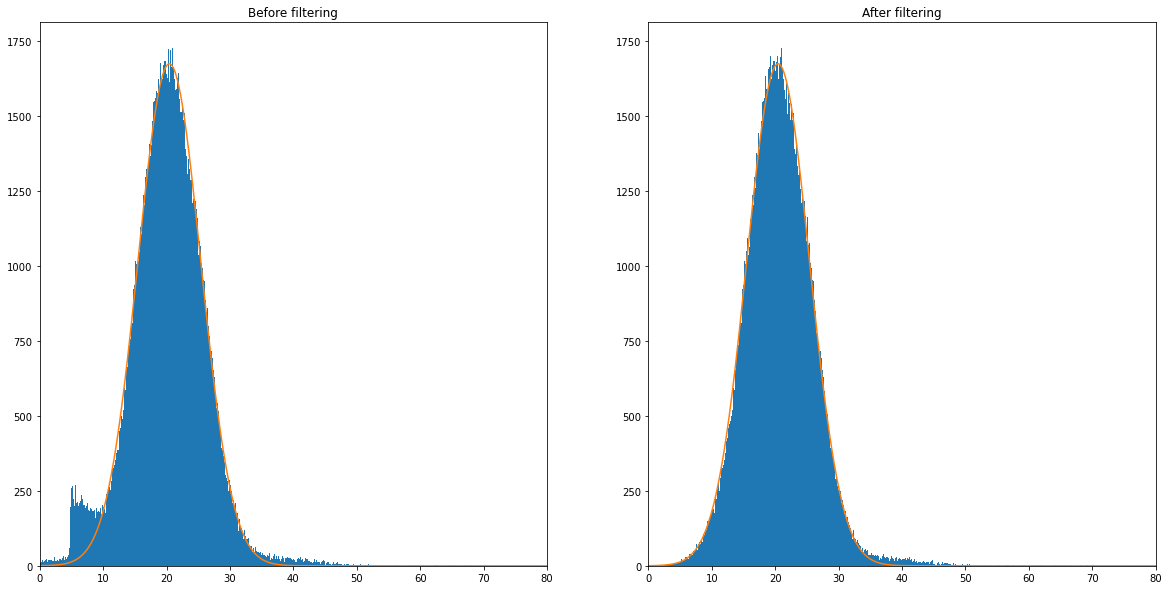

In [32]:
def event_filtering(spc_result):
    
    # Input: the list of the result; the number of bins into which we divide our result
    # Output: filtered results, as well as their x, y and A for further manipulations
    
    # Generate the list containing the intensity values
    A_list = [per.A for per in spc_result]

    # Define the edge of the bins; we only use the part of the histogram with A < gauss_max. 
    x_bins = np.linspace(0, gauss_max, _bins)
    
    # Find the value in each bin
    A_bins = np.zeros(_bins)
    for a in A_list:
        if(a < gauss_max):
            A_bins[int(a / gauss_max * _bins)] = A_bins[int(a / gauss_max * _bins)] + 1
        
    # Obtain the part of the histogram that we are going to use to perform the fit:
    start_bins = int(gauss_min / gauss_max * _bins)
    fit_A = A_bins[start_bins: ]
    fit_x = x_bins[start_bins: ]
    
    # Perform the fit
    def gaussian(x, A0, x0, sigma):
        return A0 * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
    popt, pcov = curve_fit(
        f = gaussian, # model function
        xdata = fit_x, # x data
        ydata = fit_A, # y data
        p0 = (30000, 20, 10) # initial guess of parameters
    )
    
    #Plot the histogram of intensities before filtering, along with the fitted curve
    x_ls = np.linspace(0, 80, 800)
    plt.rcParams["figure.figsize"]=[20, 10];
    fig, (before, after) = plt.subplots(ncols=2)
    before.set_xlim([0, 80])
    before.hist(A_list, bins = int(_bins / gauss_max * 80), range = [0,80]);
    before.plot(x_ls, gaussian(x_ls,popt[0],popt[1],popt[2]));
    before.set_title('Before filtering')
    
    # Start event filtering and photon counting:
    
    photon_n = 0 # Photon number
    photon_sigma = 0 # Photon uncertainty
    
    filtered_spc = []
    for per in spc_result:
        if(per.A <= 0): # Filter invalid events
            continue
        elif(per.A < gauss_min): 
            # For low intensity events, the probability of keeping this event 
            # p = value of the Gaussian fit at its intensity / # of events in the bin it belongs to, with a maximum of 1
            p = min(1, 
                    (gaussian(per.A, popt[0], popt[1], popt[2]) / 
                     max(A_bins[int(per.A / gauss_max * _bins)], 1))) # prevent the possibility of divide by zero
            
            if(np.random.rand() <= p):
                filtered_spc.append(per)
                photon_n = photon_n + per.A / popt[1]
            photon_sigma = photon_sigma + np.sqrt(p * (1 - p))
        else:
            filtered_spc.append(per)
            photon_n = photon_n + per.A / popt[1]
            if(per.A > gauss_max):
                x = min(1, per.A / popt[1] - 1)
                photon_sigma = photon_sigma + np.sqrt(x * (1 - x))
    
    x_list = [per.x for per in filtered_spc]
    y_list = [per.y for per in filtered_spc]
    A_list = [per.A for per in filtered_spc]
    
    # Plot the histogram of intensities after filtering, along with the fitted curve
    after.set_xlim([0, 80])
    after.hist(A_list, bins = int(_bins / gauss_max * 80), range = [0,80]);
    after.plot(x_ls, gaussian(x_ls,popt[0],popt[1],popt[2]));
    after.set_title('After filtering')
    
    return [[photon_n, photon_sigma], x_list, y_list, A_list, filtered_spc]
            
[photon_n, photon_sigma], x_list, y_list, A_list, filtered_spc = event_filtering(spc_result);
print('Total photon number: %d ± %d' % (photon_n, photon_sigma))


We have thus completed the single photon counting part of the algorithm, and will now use the data processed, namely the x- and y-coordinate list and intensity list to fit the spectral lines and plot the final energy spectrum.

## Bragg Spectroscopy

We first plot all the photons found:

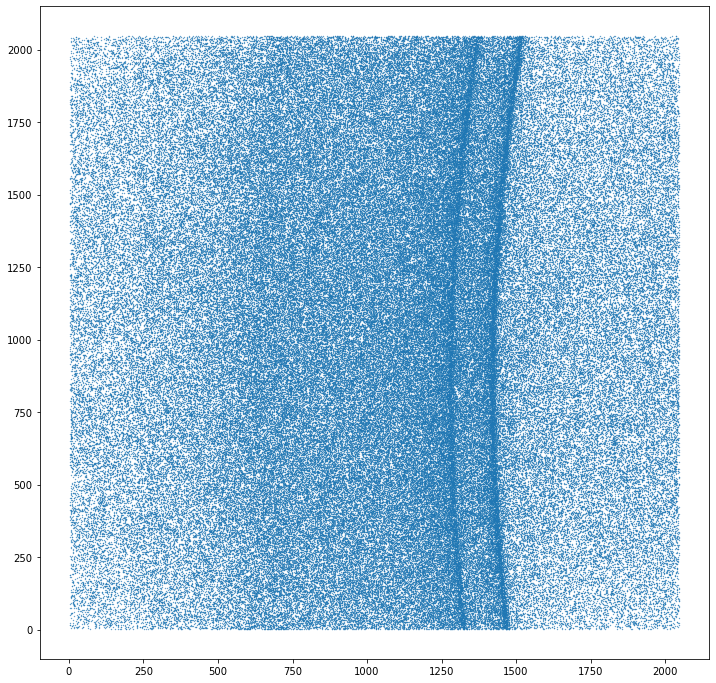

In [33]:
plt.rcParams["figure.figsize"]=[12, 12];
plt.scatter(y_list, x_list, s = 0.1)

One can see clear spectral lines on the plot. In the following steps, we will extract points that lies on the lines, use them and the knowledge of the energies of the spectral lines to fit the geometry; using that, we can find the energy associated to each photon, and plot out the final spectrum.

### Step 1: Finding points on the spectral lines

We begin by again cutting our image generated in the previous step into `fit_cut_num` strips; within each strip, we would like to fine `n` y-coordiantes having the greatest photon densities, where `n` is the number of spectral lines present. This is realised by performing the following steps:
- Within each cut, run a moving average function to calculate, for each `y`, the number of photons within the range `y` $\pm$ `half_width`. Store the result in an array, `moving_average`.
- Find the peaks by identifying the set
$$
    \left\{\mathtt{i  |  moving\_average[i] = max(moving\_average[i - peak\_width : i+peak\_width])}\right\}
$$
i.e. identifying all peaks in the moving average array; then, pick the greatest `n` entries.
- Return the set of points found in each cut.

In [34]:
# Set the parameters mentioned above
fit_cut_num = 32
half_width = 10
peak_width = 100

<b><u>Enter the energies, in units of eV, of spectral lines here, from low to high:</u></b>

In [35]:
spec_energies = 1188, 1218.5

In [36]:
# Generate the number of spectral lines
spec_n = len(spec_energies)

def moving_avg(strip_dat):
    
    # Input: data in a single strip, containing the x- and y- coordinates of photons.
    # Output: moving_average, a length (2048 - half_width) array described above.
    
    # Initialise the moving_average array:
    moving_average = np.zeros(2048 - half_width)
    
    # Iterate each photon event, and add a count to all entries in moving_average with distance < half_width
    for e in strip_dat:
        y = e[1]
        
        start = max(0, int(y) - half_width + 1)
        end = min(2048 - half_width, int(y) + half_width)
        
        moving_average[start:end] = moving_average[start:end] + 1
    
    return moving_average

def point_finding(x_list, y_list):
    
    # Input: the x- and y- coordinates of photons
    # Output: within each strip, the coordinate of n points lying on each of the spectral lines
    
    # Sort the data based on x-coordinates in order to cut it
    data = np.transpose([x_list, y_list])
    x_list, y_list = np.transpose(data[data[:, 0].argsort()])
    
    # Make sure that fit_cut_num is a factor of the size of the image, i.e. 2048. If not, raise an error.
    try:
        cut_height = int(2048/fit_cut_num)
        if(cut_height * fit_cut_num != 2048):
            raise ValueError('Invalid norm_cut_num')
    except ValueError as e:
        print('Error: ', e)
    
    point_ls = [[] for i in range(spec_n)]

    # store the cutting points in the array of coordinates
    cut_points = [0]
    
    for n in range(fit_cut_num):
        # Find the next cutting point
        for i in range(cut_points[-1], len(x_list)):
            if(x_list[i] > (n+1) * cut_height):
                # Store the cut point
                cut_points.append(i)
                break
                
        # Obtain the strip data:
        begin = cut_points[-2]
        end = cut_points[-1]
        dat = np.transpose([x_list[begin:end], y_list[begin:end]])
        moving_average = moving_avg(dat)

        # Find the peaks using methods described above:
        peaks = np.zeros([spec_n, 2]) # A n*2 array, used to store the values and positions of peaks
                
        for i in range(len(moving_average)):
            begin = max(0, i - peak_width)
            end = min(2048, i + peak_width)
            if(moving_average[i] == max(moving_average[begin:end])): # peak found
                if(i >= 5 and moving_average[i] == max(moving_average[i-5:i])): # avoid counting the same peak twice
                    continue
                if(spec_n == 1): # Only one spectral line:
                    if(moving_average[i] > peaks[0][1]):
                        peaks[0][1] = moving_average[i]
                        peaks[0][0] = i
                elif(peaks[-1][1] < moving_average[i]): # The current peak is larger than at least one of the peaks stored
                    # Remove the last entry of peaks, which, upon sorting later, is the smallest
                    peaks[-1] = (i, moving_average[i])
                    peaks = sorted(peaks, key = lambda x: x[1], reverse = True)
        
        # Sort the peaks with their coordinates, to make sure that they corresponds to the correct spectral line
        peaks = sorted(peaks, key = lambda x: x[0], reverse = True)
        # Add the peaks found to the point list; their x-coordinate is taken to be that of the middle of the strip
        for m in range(spec_n):
            point_ls[m].append([int(n * cut_height + cut_height / 2),
                                     np.transpose(peaks)[0][m] + half_width / 2]) 
            # The additional term in the second entry is to compensate for the moving average
            
    return point_ls
point_ls = point_finding(x_list, y_list)

Apply this algorithm in our data and plot the points on the scatter plot of photon events:

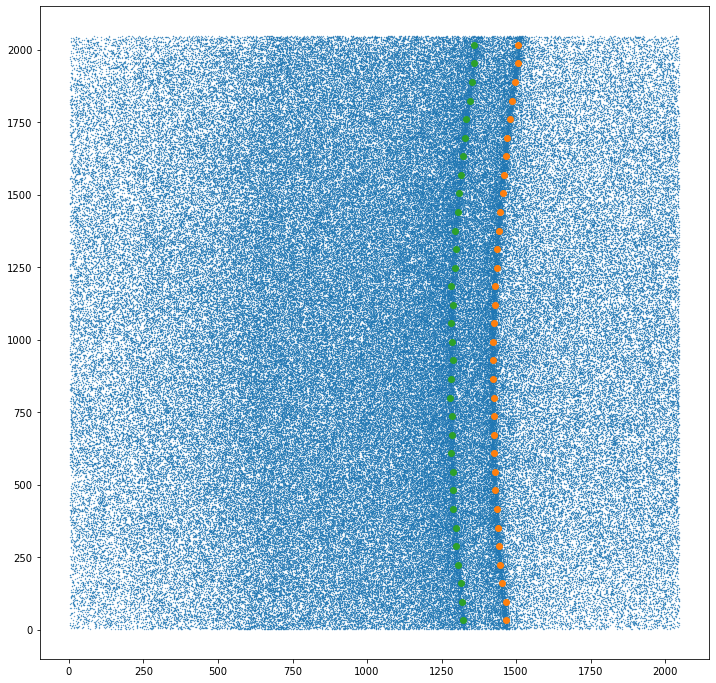

In [37]:
plt.scatter(y_list, x_list, s = 0.1)
for points in point_ls:
    point_x = np.transpose(points)[0]
    point_y = np.transpose(points)[1]
    plt.scatter(point_y, point_x)

### Step 2: Fitting the geometry

For details of this step, see the report. Here, we only claim that for each point with coordinates $x,y$, 
\begin{equation}
\begin{aligned}
    &\left\{-l\sin\alpha + \left[(x-x_0)\sin\varphi + (y-y_0)\cos\varphi\right]\cos\alpha \right\} ^2 
    + \left[(x-x_0)\cos\varphi - (y-y_0) \sin\varphi \right]^2
    \\
    &=\left\{l\cos\alpha + \left[(x-x_0)\sin\varphi + (y-y_0)\cos\varphi\right]\sin\alpha \right\} ^2 \cot^2\theta
\end{aligned}
\end{equation}

where $l$ is the distance between the deflecting beryl crystal and the camera, in units of pixels; $\alpha$ is the angle between the beryl crystal and the CCD, in radians, $\varphi$ is the angle by which the camera is rotated, and $x_0, y_0$ are the coordinate of the projection of the deflection point on the camera. They are all parameters to be determined. $\theta$ is related to the photon energy by Bragg's law:
$$
    n \frac{hc}{E}=2d \sin\theta
$$

We now use the knowledge of the spectral lines to find the five parameters $l, \alpha, \varphi, x_0, y_0$.

<b><u>Enter the values of $n$ and $2d$ in units of angstrom here:</u></b>

In [38]:
fit_n = 1
fit_2d = 15.96

<b><u>If a new set of initial values for the parameters $l, \alpha, \varphi, x_0, y_0$ are to be used, enter them here:</u></b>

In [39]:
l_init = 6000
alpha_init = 1
phi_init = 0
x0_init = 800
y0_init = 600

In [40]:
# Using Bragg's law, calculate the value of theta corresponding to each spectral line
theta_ls = [np.arcsin(fit_n * 12398.4 / (energy * fit_2d)) for energy in spec_energies]

def geometry(point_ls):
    
    # Input: the list of points obtained in previous steps
    # Output: estimation of the five parameters
    
    # Define a function to calculate the error of a single point, defined to be the square of the difference
    # of the LHS and the RHS of the above expression
    def point_error(x, y, l, alpha, phi, x0, y0, theta):
        x = x - x0
        y = y - y0

        calc_theta = np.arctan(np.sqrt(((-l * np.sin(alpha) + (x * np.sin(phi) + y * np.cos(phi)) * np.cos(alpha))**2
               + (x * np.cos(phi) - y * np.sin(phi))**2 ) /
               ((l * np.cos(alpha) + (x * np.sin(phi) + y * np.cos(phi)) * np.sin(alpha))**2))**-1)
        calc_energy = fit_n * 12398.4 / fit_2d / np.sin(calc_theta)
        real_energy = fit_n * 12398.4 / fit_2d / np.sin(theta)
        #print(calc_energy, real_energy)
        return (calc_energy - real_energy)**2
    
    # Define a function that calculates the total error, with the only parameter being a list of parameters for fitting,
    # to be used in scipy.optimize.least_squares later
    def total_error(params):
        l, alpha, phi, x0, y0 = params

        err = 0
        for i in range(len(point_ls)):
            points = point_ls[i]
            theta = theta_ls[i]
            for point in points:
                x, y = point
                err = err + point_error(x, y, l, alpha, phi, x0, y0, theta)
        return err
    
    # Set the initial array of parameters
    params = np.array([l_init, alpha_init, phi_init, x0_init, y0_init])
    
    # Use another gradient descent method to obtain the optima of parameters.
    fit_step = [3, 0.0001, 0.00001, 0.3, 0.3]
    descent_factor = 0.5
    for i in range(400):
        tot_err = total_error(params)
        err = [total_error(p) for p in params + np.diag(fit_step)] - tot_err
        params = params - fit_step * err * descent_factor
        if(tot_err < 20):
            break

    # Run a least squares fit to further optimize the result:
    res = least_squares(total_error, params, 
                        bounds = ([0, 0, -np.pi, 0, 0],[np.inf, 2 * np.pi, np.pi, 2048, 2048]),
                       verbose = 0, xtol = 1e-10
                 )
    print('The parameters fitted are: l = %dpx, alpha = %.3f, phi = %f, x0 = %.1fpx, y0 = %.1fpx' % (params[0],params[1],params[2],params[3],params[4]))
    return params

params = geometry(point_ls)

The parameters fitted are: l = 6558px, alpha = 0.982, phi = 0.000201, x0 = 820.8px, y0 = 605.4px


### Step 3: Finding the energy of each photon, plot the final spectrum

With the geometry fitted, the value of $\theta$ and hence energy of each photon can be found.

In [41]:
def energy(x, y, params):
    
    # Input: coordinates of the photon, the params fitted
    # Output: energy of the photon
    
    l, alpha, phi, x0, y0 = params
    
    x = x - x0
    y = y - y0
    
    denumerator = (-l * np.sin(alpha) + (x * np.sin(phi) + y * np.cos(phi)) * np.cos(alpha))**2 + (x *np.cos(phi) - y * np.sin(phi))**2 
    numerator = (l * np.cos(alpha) + (x * np.sin(phi) + y * np.cos(phi)) * np.sin(alpha))**2

    theta = np.arctan(np.sqrt(numerator / denumerator))
    
    # Use the energy and theta of the first spectral line to deeuce the energy:
    
    e1 = spec_energies [0]
    theta_1 = theta_ls [0]
    
    return e1 * np.sin(theta_1) / np.sin(theta)

We may now generate the final spectrum.

Note that the contribution of each photon to their energy bin is proportional to `A`. Moreover, the final intensity value of each energy bin must be multiplied by a correction factor. This is to account for the fact that, with all photons having the same energy lying on a cone, only a portion of them fall on the CCD. The angle that this portion corresponds to, $\psi$, is different for each energies. For details of this correction factor, see the report.

<b><u>Enter the values of the minimum and maximum energy here, in units of eV:</u></b>

In [42]:
min_e = 1100
max_e = 1600

In [43]:
def generate_plot(x_list, y_list, A_list, bins, _params = params):
    
    # Input: lists of coordinates and intensities of photons, the desired # of bins of the plot, and the parameters of the geometry 
    #        obtained before.
    # Output; the plot
    
    l, alpha, phi, x0, y0 = _params
    
    # Store the energies
    energies = []
    
    # Initialise the value of each energy bins
    energy_plot=np.zeros(bins)
    
    denom=1 / (max_e - min_e)
    
    # Generate correction
    def f(y, x, theta):
        x = x - x0
        y = y - y0
        return ((-l * np.sin(alpha) + (x * np.sin(phi) + y * np.cos(phi)) * np.cos(alpha))**2
                   + (x * np.cos(phi) - y * np.sin(phi))**2 
                   - (l * np.cos(alpha) + (x * np.sin(phi) + y * np.cos(phi)) * np.sin(alpha))**2 * np.tan(theta)**-2
                   )
    
    correction = []
    for i in range(bins):
        e = min_e + (max_e - min_e) / bins * i
        theta = np.arcsin(spec_energies[0] * np.sin(theta_ls[0]) / e)
        y_top = fsolve(f, 1500, args = (2048,theta))[0]
        y_bot = fsolve(f, 1500, args = (0, theta))[0]
        
        psi = []
        for x,y in [[2048, y_top],[0, y_bot]]:
            x = x - x0
            y = y - y0
            x_pp = (-l * np.sin(alpha) + (x * np.sin(phi) + y * np.cos(phi)) * np.cos(alpha))
            y_pp = (x * np.cos(phi) - y * np.sin(phi))
            psi.append(np.arctan(x_pp / y_pp))
        correction.append((2 * np.pi + psi[0] - psi[1]) / (2 * np.pi))

    # Get the value of each energy bin, by iterating all photons and add their contribution to the corresponding bins
    for i in range(len(x_list)):
        e = energy(x_list[i],y_list[i], params)
        if(e > min_e and e < max_e):
            index = int((e - min_e) * denom * bins)
            energy_plot[index]=energy_plot[index] + A_list[i] / correction[index]
    
    # Plot the final spectrum
    plt.xlim([1100,1600])
    
    plt.semilogy()
    plt.plot(np.linspace(min_e,max_e,len(energy_plot)),energy_plot);
    
    plt.ylabel('Intensity(a.u.)',fontsize = 20);
    plt.xlabel('Energy(eV)',fontsize = 20);

<b><u>Enter the number of bins in the final plot here:

In [44]:
bins = 400

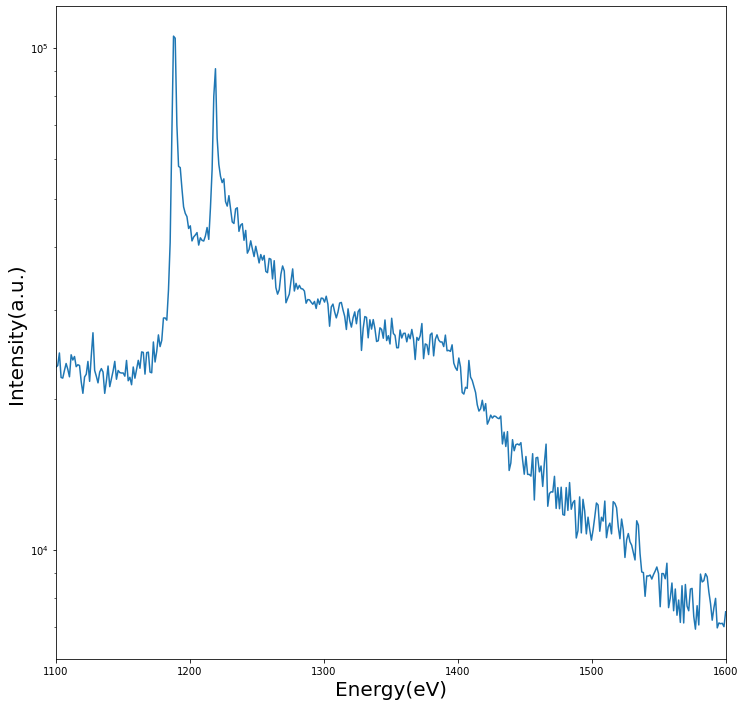

In [45]:
generate_plot(x_list, y_list, A_list, bins)

## Control group

As a comparison, the following function plots the spectrum obtained by using Bragg's spectroscopy only. The function iterates all grids and yield a value proportional to the average ADU value of the pixels within for each energy bin.

In [46]:
denom=1 / (max_e - min_e)
h, w = image_data[0].shape
energy_bin = np.zeros([h, w])
for i in range(h):
    print('\r%d' % i, end = '', flush = True)
    for j in range(w):
        e = energy(i + 0.5, j + 0.5, params)
        if(e > min_e and e < max_e):
            energy_bin[i, j] = int((e - min_e) * denom * bins)
        else:
            energy_bin[i, j] = -1

86

KeyboardInterrupt: 

In [ ]:
freq = plt.hist(energy_bin.flatten(), bins = 400, range = [0, 399])[0]
print(freq)

In [ ]:
plt.imshow(energy_bin)

In [49]:
def generate_plot_2(im_arr, bins, _params = params):
    
    # Input: an array of original images after normalisation, the desired # of bins of the plot, and the parameters of the geometry 
    #        obtained before.
    # Output; the plot
    
    l, alpha, phi, x0, y0 = _params
    
    # Store the energies
    energies = []
    
    # Initialise the value of each energy bins
    energy_plot = np.zeros(bins)
    
    # Initialise the array containing # of pixels within each energy bin, for normalisation purposes.
    freq = np.zeros(bins)
    
    denom=1 / (max_e - min_e)
    
    # Find the energy bin that each of the pixels belongs to
    h, w = image_data[0].shape
    energy_bin = np.zeros([h, w])
    for i in range(h):
        print('\rGenerating energy bin data: Line %d / %d' % (i + 1, h), end = '', flush = True)
        for j in range(w):
            e = energy(i + 0.5, j + 0.5, params)
            if(e > min_e and e < max_e):
                energy_bin[i, j] = int((e - min_e) * denom * bins)
                freq[int((e - min_e) * denom * bins)] = freq[int((e - min_e) * denom * bins)] + 1
            else:
                energy_bin[i, j] = -1
    
    
    # Generate correction
    def f(y, x, theta):
        x = x - x0
        y = y - y0
        return ((-l * np.sin(alpha) + (x * np.sin(phi) + y * np.cos(phi)) * np.cos(alpha))**2
                   + (x * np.cos(phi) - y * np.sin(phi))**2 
                   - (l * np.cos(alpha) + (x * np.sin(phi) + y * np.cos(phi)) * np.sin(alpha))**2 * np.tan(theta)**-2
                   )
    
    correction = []
    for i in range(bins):
        e = min_e + (max_e - min_e) / bins * i
        theta = np.arcsin(spec_energies[0] * np.sin(theta_ls[0]) / e)
        y_top = fsolve(f, 1500, args = (2048,theta))[0]
        y_bot = fsolve(f, 1500, args = (0, theta))[0]
        
        psi = []
        for x,y in [[2048, y_top],[0, y_bot]]:
            x = x - x0
            y = y - y0
            x_pp = (-l * np.sin(alpha) + (x * np.sin(phi) + y * np.cos(phi)) * np.cos(alpha))
            y_pp = (x * np.cos(phi) - y * np.sin(phi))
            psi.append(np.arctan(x_pp / y_pp))
        correction.append((2 * np.pi + psi[0] - psi[1]) / (2 * np.pi))

    # Get the value of each energy bin, by iterating all pxs in every image and add their contribution to the corresponding bins
    image_count = 1
    print('') # newline
    for im in im_arr:
        print('\r', 'Processing image %d' % image_count, end = '', flush = True)
        image_count = image_count + 1
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
                if(energy_bin[i, j] != -1):
                    index = int(energy_bin[i, j])
                    #print(index)
                    energy_plot[index]=energy_plot[index] + im[i,j]  / freq[index] / correction[index]
    
    # Plot the final spectrum
    plt.xlim([1100,1600])
    
    plt.semilogy()
    plt.plot(np.linspace(min_e,max_e,len(energy_plot)),energy_plot);
    
    plt.ylabel('Intensity(a.u.)',fontsize = 20);
    plt.xlabel('Energy(eV)',fontsize = 20);

 Processing image 20n data: Line 2048 / 2048

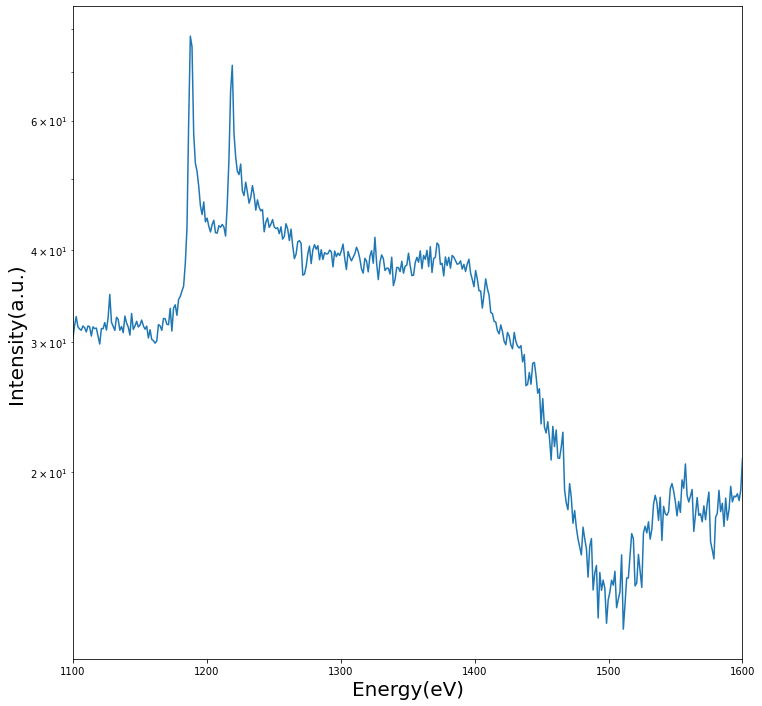

In [50]:
generate_plot_2(image_data, 400)

Not only does this method provides a false prediction of the spectrum after 1500eV, the signal-to-noise ratio is poor, with the value of ratio between maximum intensity and minimum intensity being only $\sim5$(whereas for the above method combining SPC and Bragg spectroscopy this value is about $50$), rendering Bragg spectroscopy alone not suitable when high precision is required.